# Imports

In [1]:
import pandas as pd
import matplotlib as plt
from matplotlib.pyplot import *
import numpy as np
import math
import seaborn as sns
from scipy.stats import linregress

%matplotlib inline

# Pretty colors

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

# Gather Data

In [3]:
df_2018 = pd.read_csv('2018_survey_results_public.csv',low_memory=False) 

# General cleaning and preparation

## Analyze Missing Data

I remove the columns having too much missing data.

The following columns have too much missing data:  ['TimeAfterBootcamp', 'MilitaryUS', 'HackathonReasons', 'ErgonomicDevices', 'AdBlockerReasons', 'StackOverflowJobsRecommend', 'JobEmailPriorities1', 'JobEmailPriorities2', 'JobEmailPriorities3', 'JobEmailPriorities4', 'JobEmailPriorities6', 'JobEmailPriorities5', 'JobEmailPriorities7']


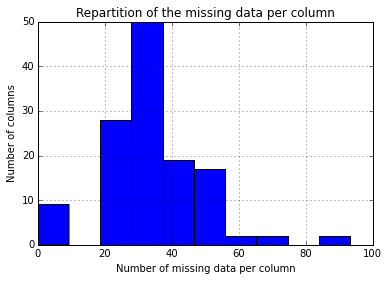

In [4]:
missing_data = ((df_2018.shape[0]-df_2018.count())/df_2018.shape[0]*100).sort_values(ascending=False)
missing_data_list = missing_data[missing_data>=53].index.tolist()
print('The following columns have too much missing data: ', missing_data_list)
missing_data.hist();
plt.pyplot.xlabel('Number of missing data per column');
plt.pyplot.ylabel('Number of columns');
plt.pyplot.title('Repartition of the missing data per column');

df_2018 = df_2018.drop(missing_data_list,axis=1)

## Analyze outliers


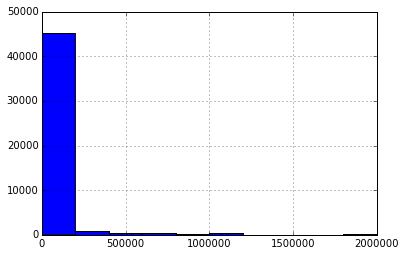

In [5]:
df_2018.ConvertedSalary.hist()
temp = df_2018[df_2018.ConvertedSalary.fillna(0)<=200000]

In [6]:
print('With this filter, we still keep %s%% of the data'% round(temp.shape[0]/df_2018.shape[0]*100,2))

With this filter, we still keep 97.48% of the data


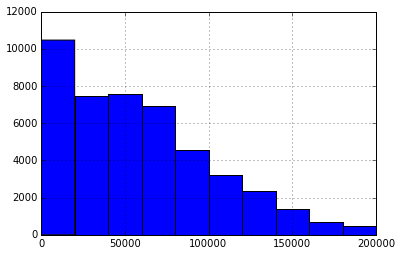

In [7]:
df_2018 = temp.copy()
df_2018.ConvertedSalary.hist();

## Define list of useful functions and dictionaries

In [8]:
def convert_str_float(x):
    '''
    INPUT
    x - string or NaN value
    
    OUTPUT
    x - as a float type
    '''
    if isinstance(x, float) and math.isnan(x):
        return x
    elif x.split()[0]=='Fewer':
        return 1
    else:
        return int(x.split()[0].split('-')[0].replace(',', ''))    
    
def split_clean(df, col):
    '''
    INPUT
    df - pandas dataframe
    col - name of an object type column of the dataframe
    
    OUTPUT
    result_df - A pandas dataframe with additional columns for each element in col splitted per ";"
    '''
    temp_list = []
    for c in df[col].value_counts().keys():
        temp_list += c.split(';')
    temp_list = [x if x[0]!=' ' else x[1::] for x in list(set(temp_list))]
    
    for c in temp_list:
        df[col+'_'+c] = df[col].apply(lambda x: np.nan if (isinstance(x, float) and math.isnan(x) ) or not c in x else 1)
    result_df = df.drop(col, axis=1)
    return result_df

def get_col(df,partial_name):
    '''
    INPUT
    df - pandas dataframe
    partial_name - a string
    
    OUTPUT
    temp_list - all the columns in the dataframe that contain the string partial_name in it
    '''
    temp_list = []
    for c in df.columns:
        if partial_name in c:
            temp_list.append(c)
    return temp_list


def define_rev(df,name_object, name_value,spec):
    '''
    INPUT
    df - pandas dataframe 
    name_object - column name of type object
    name_value - column name of type float or int
    spec - 1 for Germany, 2 for United States, 3 for India, 4 for France, otherwise no filter is apply
    
    OUTPUT
    result_df - A pandas dataframe with the average of the values in name_value per element in the name_object column. 
                The result is based on the possible filter spec.
    '''
    if spec == 1:
        df = df[df.Country == 'Germany']
    if spec ==2:
        df = df[df.Country == 'United States'] 
    if spec == 3:
        df = df[df.Country == 'India']
    if spec == 4:
        df = df[df.Country == 'France']
    
    df = df.dropna(subset=[name_object,name_value],how='any')
    
    df = df[['Age','DevType','YearsCoding','YearsCodingProf','LanguageWorkedWith','ConvertedSalary','CurrencySymbol']].copy()
    df['YearsCoding'] = df['YearsCoding'].apply(lambda x: convert_str_float(x)) 
    df['YearsCodingProf'] = df['YearsCodingProf'].apply(lambda x: convert_str_float(x)) 
    df = split_clean(df,name_object)
    name_list = get_col(df, name_object)
    
    for c in name_list:
        df[c] = [ df[c][x]*df[name_value][x] for x in df.index]
    
    index = df[name_list].mean(axis=0).index
    result_df = pd.DataFrame(index = index)
    result_df[name_value] = df[name_list].mean(axis=0).values
    
    return result_df

devtype_short = {
    'Embedded applications or devices developer':'Emb. App',
    'C-suite executive (CEO, CTO, etc.)':'C-suite',
    'DevOps specialist':'DevOps',
    'Product manager':'PM',
    'Data scientist or machine learning specialist':'Data Scientist',
    'Game or graphics developer':'Game/Graphics',
    'Data or business analyst':'Analyst',
    'Marketing or sales professional':'Marketing/Sales',
    'Engineering manager':'Eng. Manager',
    'Front-end developer':'FE',
    'Educator or academic researcher':'Academic',
    'Mobile developer':'Mobile',
    'Full-stack developer':'FE/BE',
    'Designer':'Designer',
    'QA or test developer':'QA',
    'Desktop or enterprise applications developer':'Desktop/Enterprise',
    'Database administrator':'Db Admin.',
    'Back-end developer':'BE',
    'System administrator':'Syst. Admin.'
}

# Questions of interest

I want to know which elements a recruiter should consider when hiring a tech / dev employee. 

* At what do they look at when assessing a job opportunity?
* Which type of salary is standard on the market?
* If they are interested in technologies in what kind of?
* Are they all interested in AI? What do they think of it?

## Assess job opportunity

/Users/juliasuc/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


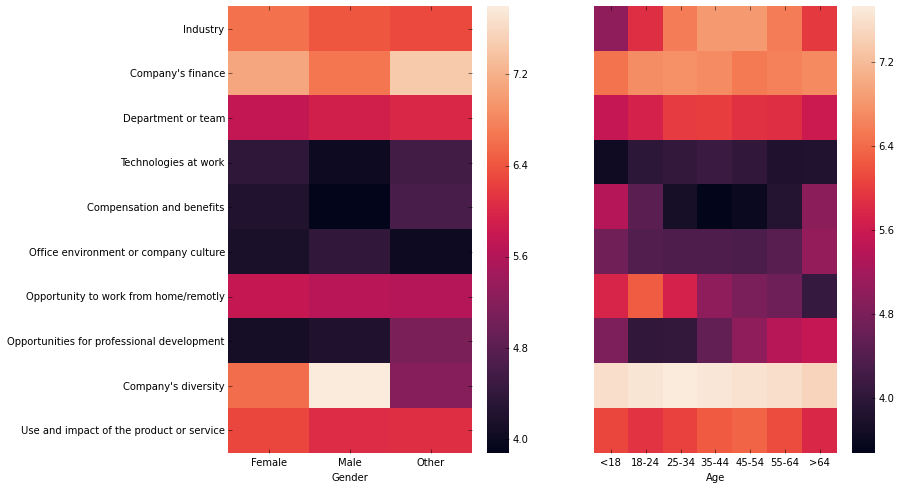

In [9]:
jo = df_2018.copy()

gender_dict = {'Male':'Male','Female':'Female'}
for c in df_2018.Gender.value_counts().index:
    if not c in gender_dict:
        gender_dict[c] = 'Other'
jo.Gender = jo.Gender.apply(lambda x: x if isinstance(x, float) and math.isnan(x) else gender_dict[x])

assessJob_list = ['AssessJob'+str(x) for x in range(1,11)]
assessJobName_list = ['Industry','''Company's finance''','Department or team','Technologies at work','Compensation and benefits','Office environment or company culture','Opportunity to work from home/remotly','Opportunities for professional development','''Company's diversity''','Use and impact of the product or service']
jo = jo.groupby(['Gender']).mean()[assessJob_list]
jo.columns = assessJobName_list
jo = jo.transpose()
plt.pyplot.figure(figsize=(12,8));
ax = plt.pyplot.subplot(121) 
sns.heatmap(jo)

jo = df_2018.copy()
assessJob_list = ['AssessJob'+str(x) for x in range(1,11)]
assessJobName_list = ['Industry','''Company's finance''','Department or team','Technologies at work','Compensation and benefits','Office environment or company culture','Opportunity to work from home/remotly','Opportunities for professional development','''Company's diversity''','Use and impact of the product or service']
jo = jo.groupby(['Age']).mean()[assessJob_list]
jo.columns = assessJobName_list
jo = jo.reindex(['Under 18 years old', '18 - 24 years old', '25 - 34 years old','35 - 44 years old','45 - 54 years old',
                           '55 - 64 years old','65 years or older'])
jo = jo.transpose()
jo.columns = pd.Series(['<18', '18-24', '25-34','35-44','45-54',
                           '55-64','>64'],name='Age')
ax = plt.pyplot.subplot(122) 
sns.heatmap(jo,yticklabels=False)
plt.pyplot.xticks(rotation=0)


plt.pyplot.savefig("heatmap-JobAssessment.png", bbox_inches="tight")

Compensation and benefits, technology, professional development and company's culture appear as a common feature of importance. However, our choices evolve as we grow up. If industry is important at the beginning of our career, it becomes less relevant with the experience. It becomes increasingly important for the groups 55–64 and >64 years old, potentially because they have acquired a long experience in a specific industry. This generation is also more used to do career inside the same company.

Working from home is also a valuable benefit, which importance raises as we age. This reflects also private developments: couple starting building a family.

Unsurprisingly, company's diversity is taken more at heart… by the minorities, here represented by the gender minorities versus the male group.

## Asses Job Benefits

/Users/juliasuc/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


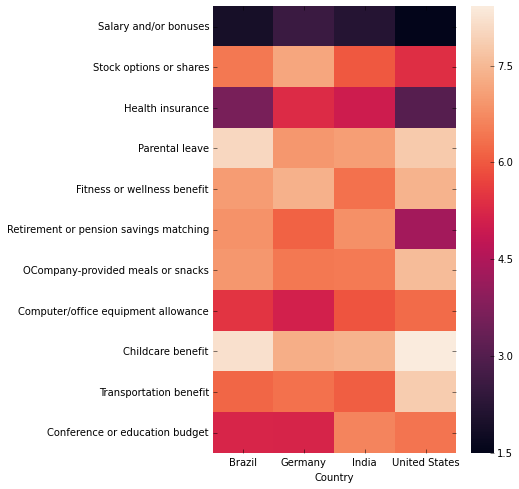

In [10]:
jo = df_2018.copy()
jo = jo[jo.Country.isin(['India','United States','Germany','Brazil'])]
gender_dict = {'Male':'Male','Female':'Female'}
for c in df_2018.Gender.value_counts().index:
    if not c in gender_dict:
        gender_dict[c] = 'Other'
jo.Gender = jo.Gender.apply(lambda x: x if isinstance(x, float) and math.isnan(x) else gender_dict[x])

assessJob_list = ['AssessBenefits'+str(x) for x in range(1,12)]
assessJobName_list = ['Salary and/or bonuses','''Stock options or shares''','Health insurance','Parental leave','Fitness or wellness benefit','Retirement or pension savings matching','OCompany-provided meals or snacks','Computer/office equipment allowance','''Childcare benefit''','Transportation benefit','Conference or education budget']
jo = jo.groupby(['Country']).mean()[assessJob_list]
jo.columns = assessJobName_list
jo = jo.transpose()
plt.pyplot.figure(figsize=(12,8));
ax = plt.pyplot.subplot(121) 
sns.heatmap(jo)

plt.pyplot.savefig("heatmap-BenefitAssessment.png", bbox_inches="tight")

Benefits definitely depend on the geographical location. The graph details the ranking of common job benefits: 1 being for the most crucial. 

Health insurance provided by the company is definitely a more important topic in US than in Germany reflecting the differences in the healthcare systems. Stock options as well retirement savings matching are also more welcomed in the US.

## Analyze average revenue and years of coding experience per dev type

In [11]:
def plot_scatter(df,xaxis,yaxis,xlabel,ylabel,file_name,show_linreg = False, dict_short = None, xmin = None):
    '''
    INPUT
    df - pandas dataframe
    xaxis - column name
    yaxis - column name
    xlabel - x-axis title
    ylabel - y-axis title
    file_name - name of the file to be saved
    
    OPTIONAL
    linreg - True if a linear regression should be displayed, False by default
    dict_short - dictionary of abreviation of the dataframe's index, by default the index values are displayed
    xmin - minimum value on the x-axis
    
    OUTPUT
    '''
    temp_ = df.copy()
    temp_.index = [x.split('_')[1] for x in temp_.index]
    
    fig, ax = plt.pyplot.subplots(figsize=(14,10));
    plt.pyplot.scatter(temp_[xaxis],temp_[yaxis],color=tableau20[0]);
    
    if show_linreg: 
        ln = linregress(temp_[xaxis],temp_[yaxis])
        y = [ln.intercept + ln.slope*x for x in temp_[xaxis]]
        plt.pyplot.plot(temp_[xaxis],y,color=tableau20[1])
    
    
    for i in temp_.index :
        xextra = 0.05
        yextra = 500
        if dict_short == None:
            ax.annotate(i, (temp_[xaxis][i]+xextra, temp_[yaxis][i]+yextra))
        else:
            ax.annotate(dict_short[i], (temp_[xaxis][i]+xextra, temp_[yaxis][i]+yextra))
        
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)  
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left() 
    
    x_min = max(0,int(temp[xaxis].min()-1) ) if xmin == None else max(0,int(temp[xaxis].min()) )
    x_max = int(temp[xaxis].max()+1)
    y_min = int((round(temp[yaxis].min()/10000)-1)*10000)
    y_max = int((round(temp[yaxis].max()/10000)+1)*10000)
    
    for y in range(y_min, y_max+10000, 10000):    
        plt.pyplot.plot(range(x_min-1, x_max+1),[y] * len(range(x_min-1,x_max+1)), "--", lw=0.5, color="black", alpha=0.3) 
    
    ax.get_yaxis().set_major_formatter(plt.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.pyplot.xlabel(xlabel)
    plt.pyplot.ylabel(ylabel)
    plt.pyplot.xlim((x_min, x_max))
    plt.pyplot.ylim((y_min, y_max))
    
    plt.pyplot.savefig(file_name, bbox_inches="tight")
    return



/Users/juliasuc/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


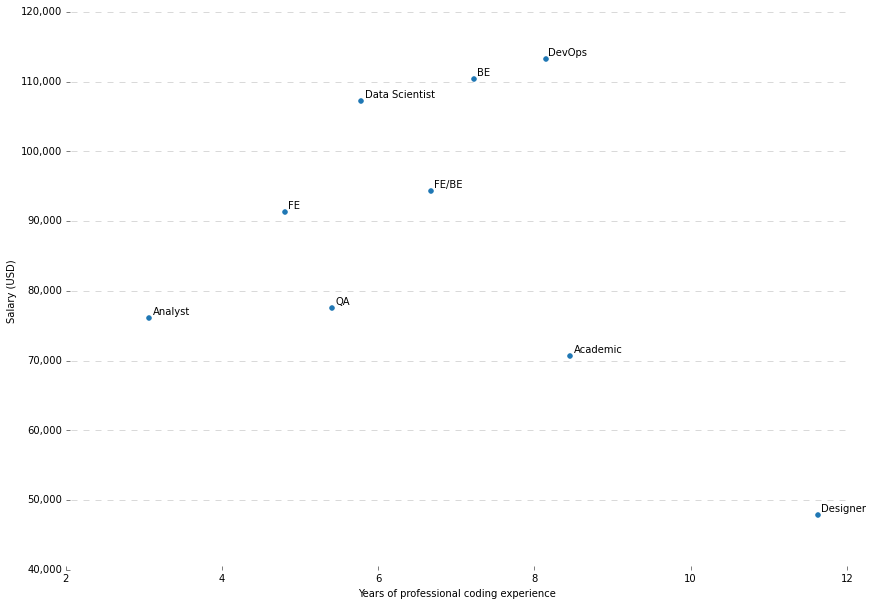

In [15]:
df = df_2018[df_2018.DevType.isin(
        ['Designer','Front-end developer','Back-end developer',
         'Full-stack developer','QA or test developer','DevOps specialist',
      'Data or business analyst','Data scientist or machine learning specialist',
         'Educator or academic researcher']
    )].copy()


rev_devtype1 = define_rev(df,'DevType', 'ConvertedSalary',2)
rev_devtype2 = define_rev(df,'DevType', 'YearsCodingProf',2)
temp = pd.concat([rev_devtype1,rev_devtype2],axis=1)

plot_scatter(temp,'YearsCodingProf','ConvertedSalary','Years of professional coding experience','Salary (USD)',"salaryF.png",False,devtype_short)

They are multiple parameters which explain salary's differences. So let's rather have a look at the current situation over the Stack Overflow participants.

The majority of the respondents are coming from the US therefore the data set has been restrained to them. 
The participants have provided information on their previous experiences in different domains. Therefore, someone doing full-stack today certainly reported experience as a front-end developer as well as back-end developer. To not use inflated numbers, the first graph only represents the average salary and the average years of coding experience for participants reporting only one type of experience.

What can we say? 

* QA and front-end jobs are rather done by juniors
* QA claims a rather lower salary
* While Data Scientists are often relatively juniors, they are in the upper part of the salary scale
* DevOps specialists have the highest salaries. They seem to be people with more experience. The salary can also be explained by the fact that they are often required to work on call to monitor the system.

/Users/juliasuc/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/juliasuc/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


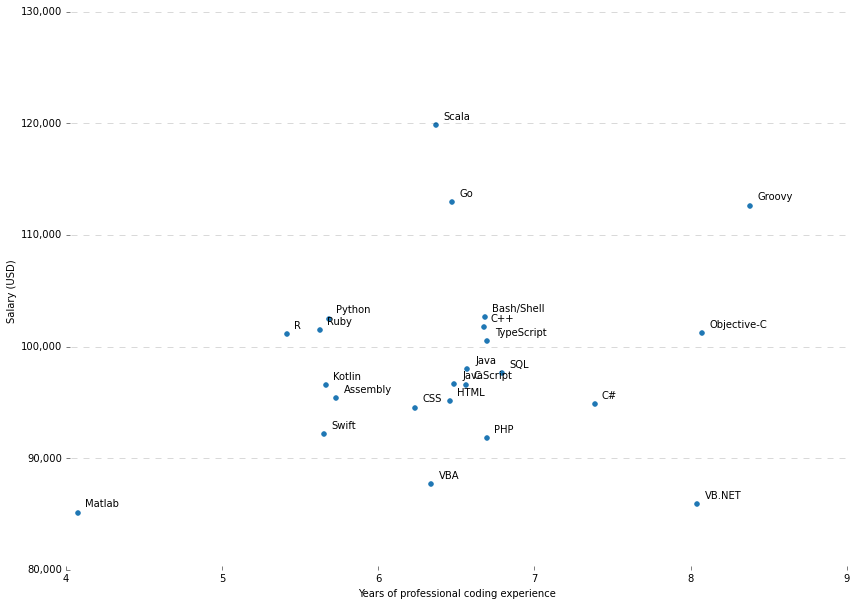

In [16]:
df = df_2018[df_2018.DevType.isin(
        ['Designer','Front-end developer','Back-end developer',
         'Full-stack developer','QA or test developer','DevOps specialist',
      'Data or business analyst','Data scientist or machine learning specialist',
         'Educator or academic researcher']
    )].copy()

temp_la = df_2018.dropna(subset=['ConvertedSalary','YearsCodingProf'],how='any',axis=0)[['LanguageWorkedWith']].copy()
temp_la = split_clean(temp_la,'LanguageWorkedWith')
temp2 = (temp_la.count()/temp_la.shape[0]*100).sort_values(ascending=False)
languages = temp2[temp2>4.3].index.tolist()

rev_devtype1 = define_rev(df,'LanguageWorkedWith', 'ConvertedSalary',2)
rev_devtype2 = define_rev(df,'LanguageWorkedWith', 'YearsCodingProf',2)
temp = pd.concat([rev_devtype1,rev_devtype2],axis=1)
temp = temp[temp.index.isin(languages)]

plot_scatter(temp,'YearsCodingProf','ConvertedSalary','Years of professional coding experience','Salary (USD)',"salaryLanguage.png",False,None,4)

Ruby, Python/R, Scala, Go, C++ rank on the top for back end part!
It is interesting to notice that people using Python/R have less coding experience than people using VBA. This shows the shift in the younger generations to the Python and R statistical tools.

## Look at the JobSearch Status per devtype


/Users/juliasuc/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


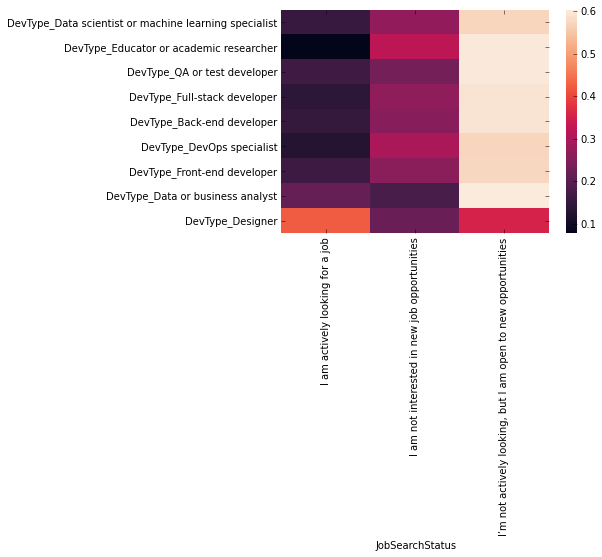

In [17]:
jo = df_2018[df_2018.DevType.isin(
        ['Designer','Front-end developer','Back-end developer',
         'Full-stack developer','QA or test developer','DevOps specialist',
      'Data or business analyst','Data scientist or machine learning specialist',
         'Educator or academic researcher']
    )].copy()
jo = jo[['DevType','JobSearchStatus']].copy().dropna(how='all')
jo = split_clean(jo,'DevType')
name_list = get_col(jo, 'DevType')

temp=jo.groupby(['JobSearchStatus']).sum()[name_list]
temp = temp.transpose()
temp['sum'] = temp.sum(axis=1)
for c in temp.columns:
    if c!='sum':
        temp[c] = temp[c]/temp['sum']
temp = temp.drop('sum',axis=1)
sns.heatmap(temp);



## Technologies of Interest

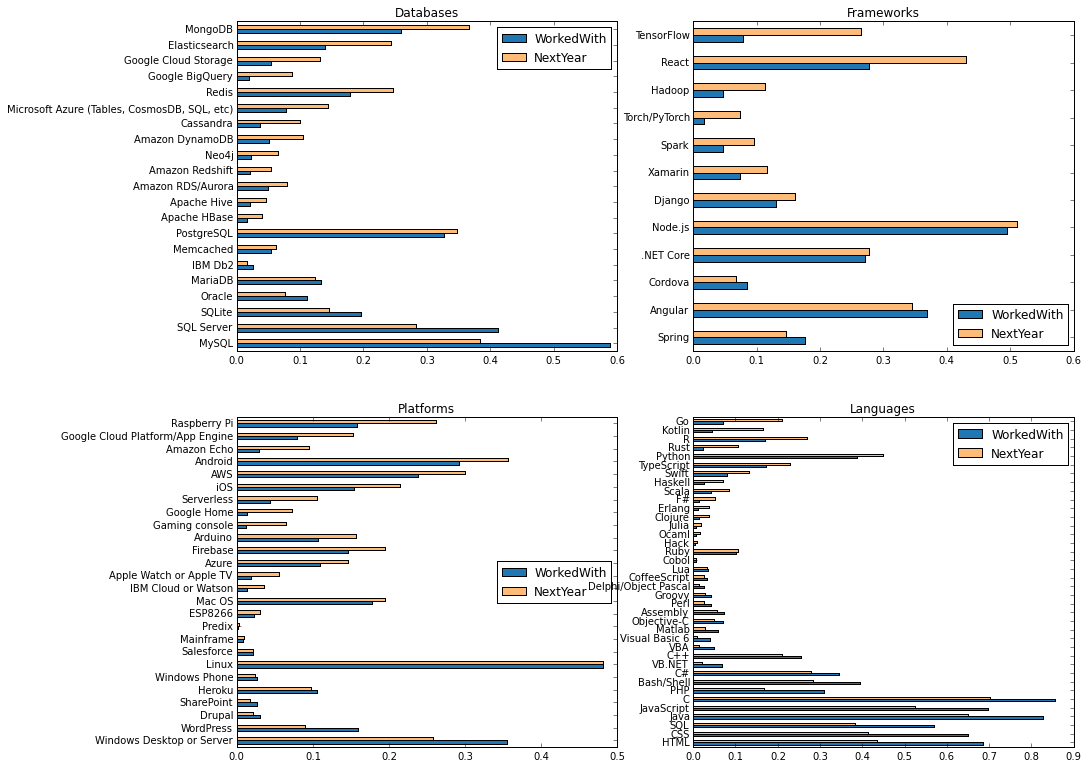

In [18]:
def plot_workedwith_vs_nextyear(df,t1,t2,title,ax):
    '''
    INPUT
    df - pandas dataframe
    t1 - column's name such as 'DatabaseWorkedWith', 'FrameworkWorkedWith', 'LanguageWorkedWith', 'PlatformWorkedWith'
    t2 - column's name such as 'DatabaseNextYear', 'FrameworkNextYear', 'LanguageNextYear', 'PlatformNextYear'
    title - title of the plot
    ax - graph's axes on which the figure should be plotted
    
    RETURN
    A bar plot comparing the percentage of positive answer per technology to the questions "WorkedWith" or want to work 
    with it "NextYear"
    
    '''
    workwith = get_col(df,t1)
    nextyear = get_col(df,t2)
    
    df1 = df.dropna(subset=workwith,how='all')
    sum1 = df1.shape[0]
    temp_df_1 = df1[workwith].sum()
    
    index_list = []
    for c in temp_df_1.index:
        index_list.append(c.split('_')[1])
    temp_df_1.index = index_list
    
    df2 = df.dropna(subset=nextyear,how='all')
    sum2 = df2.shape[0]
    
    temp_df_2 = df2[nextyear].sum()
    index_list = []
    for c in temp_df_2.index:
        index_list.append(c.split('_')[1])
    temp_df_2.index = index_list

    temp_df = pd.concat([temp_df_1/sum1,temp_df_2/sum2], axis=1, sort='False')
    
    temp_df.columns= ['WorkedWith', 'NextYear']
    temp_df['diff'] = temp_df.NextYear - temp_df.WorkedWith
    temp_df = temp_df.sort_values(by='diff',ascending=True)
    temp_df = temp_df.drop(['diff'],axis=1)
    temp_df.plot(kind='barh',title=title,ax=ax,figsize=(15,13),color=tableau20[0:1]+tableau20[3:4])
    return


temp_2018 = df_2018.copy()
temp_2018 = split_clean(temp_2018,'DevType')
temp_2018 = split_clean(temp_2018,'LanguageWorkedWith')
temp_2018 = split_clean(temp_2018,'LanguageDesireNextYear')
temp_2018 = split_clean(temp_2018,'DatabaseWorkedWith')
temp_2018 = split_clean(temp_2018,'DatabaseDesireNextYear')
temp_2018 = split_clean(temp_2018,'PlatformWorkedWith')
temp_2018 = split_clean(temp_2018,'PlatformDesireNextYear')
temp_2018 = split_clean(temp_2018,'FrameworkWorkedWith')
temp_2018 = split_clean(temp_2018,'FrameworkDesireNextYear')

#temp_2018=temp_2018[temp_2018['DevType_Front-end developer']==1] 

plt.pyplot.Figure()
ax1 = plt.pyplot.subplot(221) 
plot_workedwith_vs_nextyear(temp_2018,'DatabaseWorkedWith','DatabaseDesireNextYear','Databases',ax1)

ax2 = plt.pyplot.subplot(222) 
plot_workedwith_vs_nextyear(temp_2018,'FrameworkWorkedWith','FrameworkDesireNextYear','Frameworks',ax2)

ax3 = plt.pyplot.subplot(223) 
plot_workedwith_vs_nextyear(temp_2018,'PlatformWorkedWith','PlatformDesireNextYear','Platforms',ax3)

ax4 = plt.pyplot.subplot(224) 
plot_workedwith_vs_nextyear(temp_2018,'LanguageWorkedWith','LanguageDesireNextYear','Languages',ax4)

plt.pyplot.savefig("tech-Assessment.png", bbox_inches="tight")

The graphs are ranked based on the difference between the percentage of respondents interested in learning about the technology and the percentage of respondents having experience with it.

Analytics and machine learning topics keep their momentum with popular languages like R or Python or platforms like TensorFlow. Cloud or big data areas are also of interest and Go language keeps its popularity as also shown in the TIOBE index.

The answers actually reflect the appetite for novelty and the interest of tech people in staying at the front edge of technology.

# Analyze AI Questions

## AI Future

I'm excited about the possibilities more than worried about the dangers.        72.732941
I'm worried about the dangers more than I'm excited about the possibilities.    19.086644
I don't care about it, or I haven't thought about it.                            8.180415
Name: AIFuture, dtype: float64

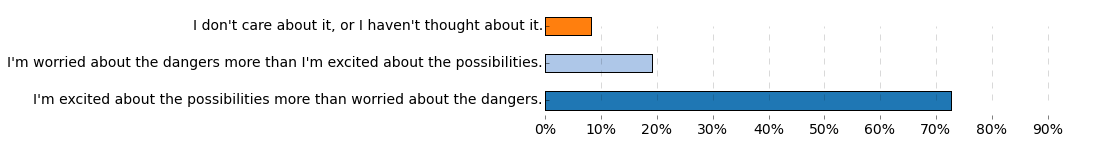

In [19]:
plt.pyplot.figure(figsize=(10, 2))    
ax = plt.pyplot.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
plt.pyplot.xticks(range(0, 100, 10), [str(x) + "%" for x in range(0, 100, 10)], fontsize=14)    
plt.pyplot.yticks(fontsize=14) 
for y in range(10, 110, 10):    
    plt.pyplot.plot([y] * len(range(0,3)),range(0, 3), "--", lw=0.5, color="black", alpha=0.3) 


(df_2018.AIFuture.value_counts()/df_2018.AIFuture.value_counts().sum()*100).plot(kind='barh',color=tableau20[0:3],width=0.5)

plt.pyplot.savefig("percent-AI-Future.png", bbox_inches="tight")

(df_2018.AIFuture.value_counts()/df_2018.AIFuture.value_counts().sum()*100)

/Users/juliasuc/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


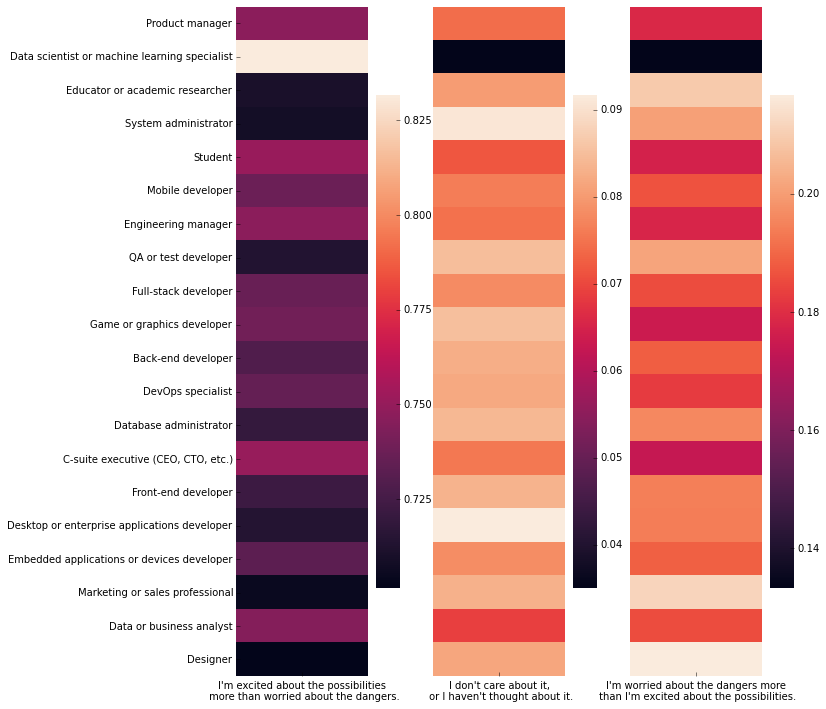

In [20]:
def plot_heat_map(df,ax,name,convertedName,display_ylabel=False):  
    '''
    INPUT
    df - pandas dataframe
    ax - axis on which the figure has to be plotted
    name - column name
    convertedName - name to be displayed on the x-axis
    display_y_label - True if the y-labels should be displayed, False by default
    
    OUTPUT
    Return a heat map plot for the column name of dataframe df
    '''
    ax.spines["top"].set_visible(False)       
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)       
    ax.spines["left"].set_visible(False)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left() 
    df = df[[name]]
    df.columns= [convertedName]
    list_display = [x.split('_')[1] for x in df.index.tolist()]
    if display_ylabel:
        sns.heatmap(df,yticklabels=list_display,xticklabels=df.columns.values)
    else:
        sns.heatmap(df,yticklabels=False,xticklabels=df.columns.values)
    return

devtype_list = get_col(temp_2018,'DevType')
temp=temp_2018.groupby('AIFuture').sum()[devtype_list].copy().reset_index()
temp.index = temp.AIFuture
temp = temp.drop(['AIFuture'],axis=1)
temp = temp.transpose()
temp['sum'] = temp.sum(axis=1)
for c in temp.columns:
    if c!= 'sum':
        temp[c] = temp[c]/temp['sum']
temp = temp.drop(['sum'],axis=1)

plt.pyplot.figure(figsize=(10, 12))    
ax = plt.pyplot.subplot(131)    
convertedName = '''I'm excited about the possibilities \n more than worried about the dangers.'''
name = '''I'm excited about the possibilities more than worried about the dangers.'''
plot_heat_map(temp,ax,name,convertedName,True)


ax2 = plt.pyplot.subplot(132)    
convertedName = '''I don't care about it, \n or I haven't thought about it.'''
name = '''I don't care about it, or I haven't thought about it.'''
plot_heat_map(temp,ax2,name,convertedName)


ax3 = plt.pyplot.subplot(133)    
convertedName = '''I'm worried about the dangers more \n than I'm excited about the possibilities.'''
name = '''I'm worried about the dangers more than I'm excited about the possibilities.'''
plot_heat_map(temp,ax3,name,convertedName)

plt.pyplot.savefig("heatmap-AI-Future.png", bbox_inches="tight")

Without surprise, Data Scientists and Business Analysts are the most enthusiastic about Artificial Intelligence as they are driving it. They are also well supported by C-suite executive and product manager who are aware of the challenges but seem to be a bit more careful regarding the implications. 

On the other side, marketing, sales professionals and designers as well as academic researchers are the most critic. Academicians are certainly the one reflecting the most on their daily work about the implications of data science.

## AIDangerous vs Country

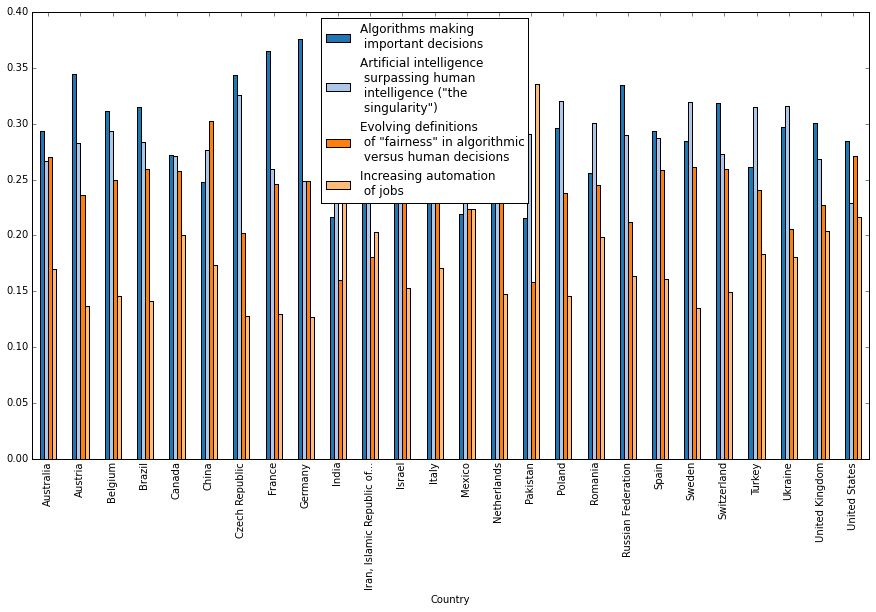

In [21]:
co = df_2018['Country'].value_counts()
countries = co[co>700].index.tolist()
answer_dict = {'Algorithms making important decisions':'Algorithms making \n important decisions',
              'Artificial intelligence surpassing human intelligence ("the singularity")':'Artificial intelligence \n surpassing human \n intelligence ("the \n singularity")',
              'Evolving definitions of "fairness" in algorithmic versus human decisions':'Evolving definitions \n of "fairness" in algorithmic \n versus human decisions',
              'Increasing automation of jobs':'Increasing automation \n of jobs'}

ai = df_2018[df_2018.Country.isin(countries)].copy()
ai.AIDangerous = ai.AIDangerous.apply(lambda x: x if (isinstance(x, float) and math.isnan(x) ) else answer_dict[x] )
ai['Count'] = 1
ai = ai.groupby(['Country','AIDangerous']).sum()

ti = ai.copy()
country_dict = ti.reset_index().groupby(['Country']).sum()['Count'].to_dict()

ai['Count'] = [ ai['Count'][x]/country_dict[x[0]]  for x in ai.index]
fig, ax = subplots()
ai['Count'].unstack().plot(figsize = (15,8),kind='bar',ax=ax,color=tableau20)
ax.legend(bbox_to_anchor=(0.6, 1));

/Users/juliasuc/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


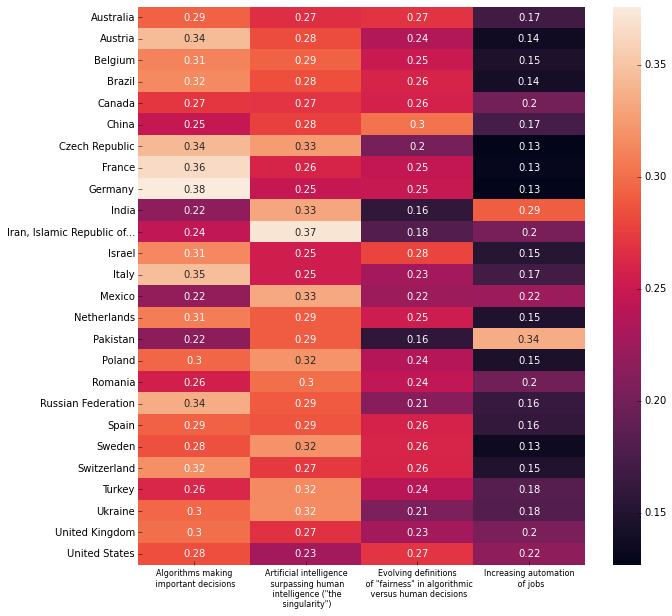

In [22]:
plt.pyplot.figure(figsize=(10,10))
ax = plt.pyplot.subplot(111)    
ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)       
ax.spines["left"].set_visible(False)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
temp_ = ai.copy()
temp_ = temp_['Count'].unstack()
temp_.index=temp_.index.tolist()
temp_.columns=temp_.columns.tolist()
sns.heatmap(temp_,annot=True,yticklabels=temp_.index,xticklabels=temp_.columns.values)
plt.pyplot.xticks(rotation=0,fontsize = 8) 

plt.pyplot.savefig("heatmap-AI-Dangerous.png", bbox_inches="tight")

Indeed, even if the dangers of AI seem well distributed from job automatization to the creation of a super-intelligence beyond humans, some trends can be spotted. In Pakistan or in India, the risk of an increase in job automation is highlighted much more strongly while others are more worried about AI making decisions or surpassing human intelligence.

## AI Dangerous vs Age

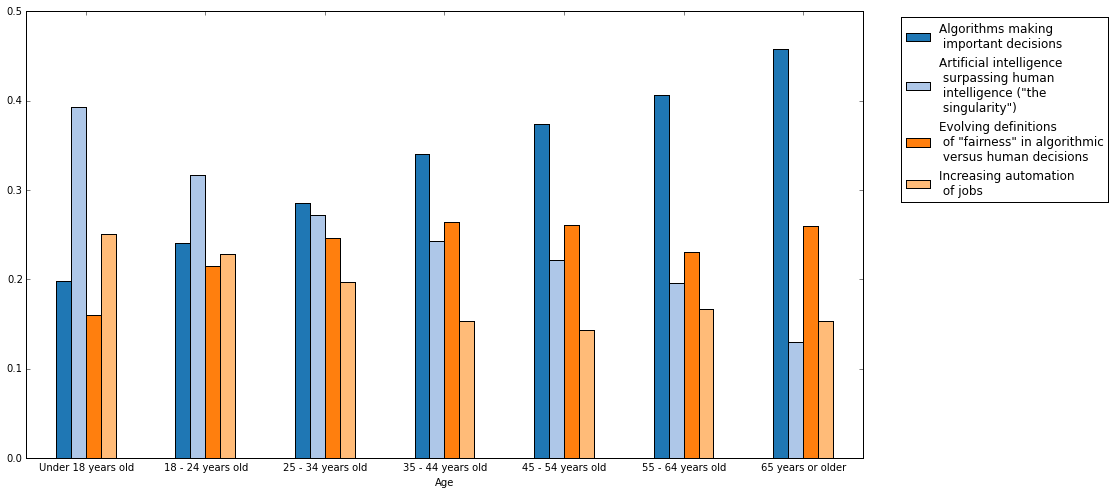

In [23]:
co = df_2018['Country'].value_counts()
countries = co[co>0].index.tolist()
answer_dict = {'Algorithms making important decisions':'Algorithms making \n important decisions',
              'Artificial intelligence surpassing human intelligence ("the singularity")':'Artificial intelligence \n surpassing human \n intelligence ("the \n singularity")',
              'Evolving definitions of "fairness" in algorithmic versus human decisions':'Evolving definitions \n of "fairness" in algorithmic \n versus human decisions',
              'Increasing automation of jobs':'Increasing automation \n of jobs'}

ai = df_2018[df_2018.Country.isin(countries)].copy()
ai.AIDangerous = ai.AIDangerous.apply(lambda x: x if (isinstance(x, float) and math.isnan(x) ) else answer_dict[x] )
ai['Count'] = 1
ai = ai.groupby(['Age','AIDangerous']).sum()

ti = ai.copy()
age_dict = ti.reset_index().groupby(['Age']).sum()['Count'].to_dict()

ai['Count'] = [ ai['Count'][x]/age_dict[x[0]]  for x in ai.index]
fig, ax = subplots()

ai=ai.Count.unstack().reindex(['Under 18 years old', '18 - 24 years old', '25 - 34 years old','35 - 44 years old','45 - 54 years old',
                           '55 - 64 years old','65 years or older'])
ai.plot(figsize = (15,8),kind='bar',ax=ax,color=tableau20);
ax.legend(bbox_to_anchor=(1.3, 1))
plt.pyplot.xticks(rotation=0) 
plt.pyplot.savefig("percent-AI-Dangerous-Age.png", bbox_inches="tight")

Generation Z believes in AI, they were born with its start and they will bring it to the next revolution. 

On the over hand, more experienced people are more worried about the current increased impact of AI in our everyday life. While intelligent algorithms are becoming prevalent in most aspects of decision making involving humans and machine, their bias, lack of transparency and accountability is raising concerns. Moreover, their deployments are fast… much faster than the legislation, which makes it a challenge for the society.


## Analyse communication tools used by companies

/Users/juliasuc/anaconda/lib/python3.5/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


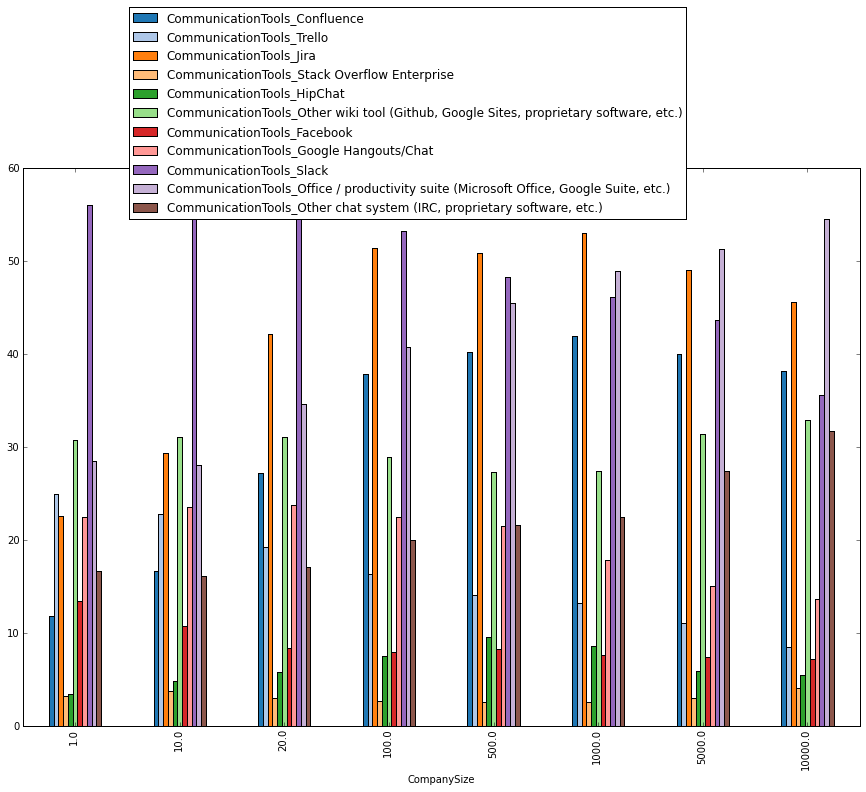

In [318]:
tp_2018 = df_2018.copy()
tp_2018['sum'] = tp_2018['CommunicationTools'].apply(lambda x: 0 if (isinstance(x, float) and math.isnan(x)) else 1)

tp_2018['CompanySize'] = tp_2018['CompanySize'].apply(lambda x: convert_str_float(x) )
sum_temp = tp_2018.groupby('CompanySize').sum()['sum']

tp_2018 = split_clean(tp_2018,'CommunicationTools')
comm_tool_list =get_col(tp_2018,'CommunicationTools')
comm_temp = tp_2018.groupby('CompanySize').sum()[comm_tool_list]
comm_temp=pd.concat([comm_temp,sum_temp],axis=1)

comm_temp = comm_temp.div(comm_temp["sum"]/100, axis=0)
comm_temp = comm_temp.drop('sum',axis=1)
comm_temp.plot(kind='bar',figsize=(15,10),colors = tableau20)
plt.pyplot.legend(bbox_to_anchor=(0.8, 1.3));

## AI Responsible

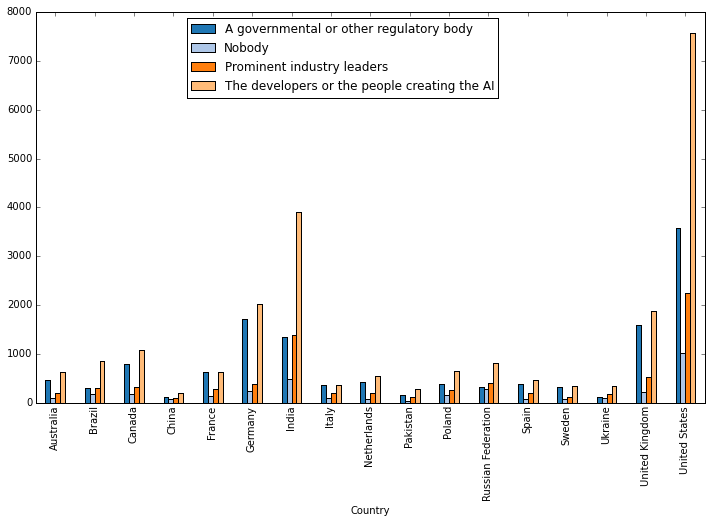

In [319]:
df_2018['Count'] = 1
co = df_2018['Country'].value_counts()
countries = co[co>1000].index.tolist()
ai = df_2018[df_2018.Country.isin(countries)].copy()

ai = ai.groupby(['Country','AIResponsible']).count()
fig, ax = subplots()
ai['Count'].unstack().plot(figsize = (12,7),kind='bar',ax=ax,color=tableau20);
ax.legend(bbox_to_anchor=(0.7, 1));

According to the data it seems that in countries with a strong government (like in in Europe with the "Providence" state), people expect much more from government, which isn't so surprising.

## AI Interesting

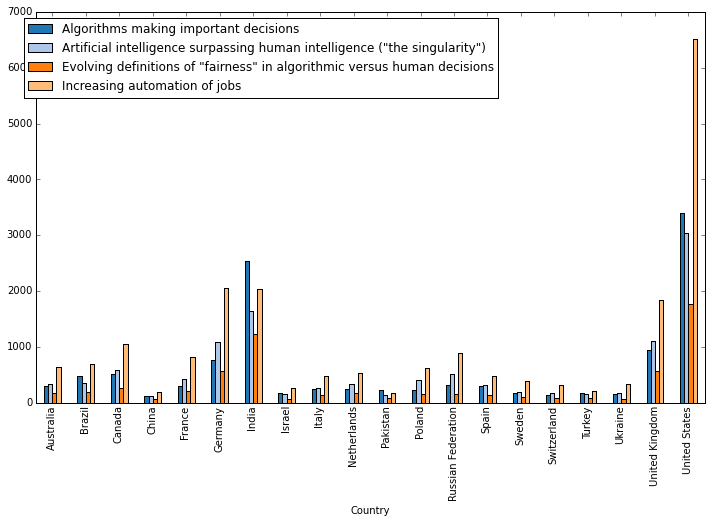

In [116]:
df_2018['Count'] = 1
co = df_2018['Country'].value_counts()
countries = co[co>1000].index.tolist()
ai = df_2018[df_2018.Country.isin(countries)].copy()

ai = ai.groupby(['Country','AIInteresting']).count()
fig, ax = subplots()
ai['Count'].unstack().plot(figsize = (12,7),kind='bar',ax=ax,color=tableau20);
ax.legend(bbox_to_anchor=(0.7, 1));

## Ethics choice
Results always similar

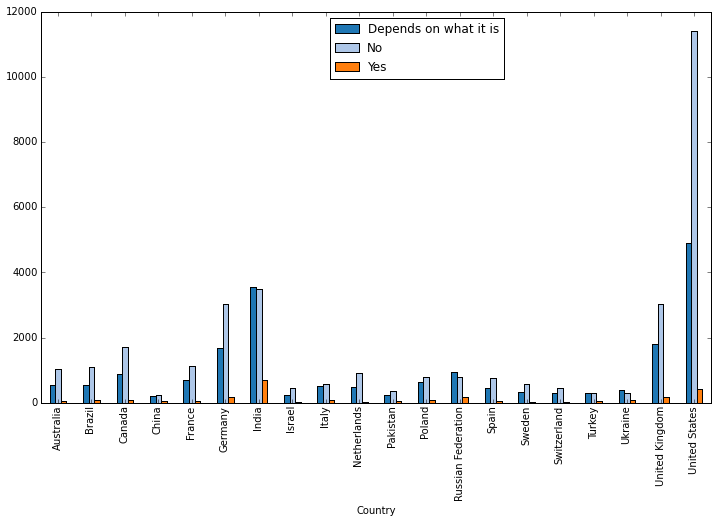

In [118]:
df_2018['Count'] = 1
co = df_2018['Country'].value_counts()
countries = co[co>1000].index.tolist()
ai = df_2018[df_2018.Country.isin(countries)].copy()

ai = ai.groupby(['Country','EthicsChoice']).count()
fig, ax = subplots()
ai['Count'].unstack().plot(figsize = (12,7),kind='bar',ax=ax,color = tableau20);
ax.legend(bbox_to_anchor=(0.7, 1));

## Ethics Report
Results always similar

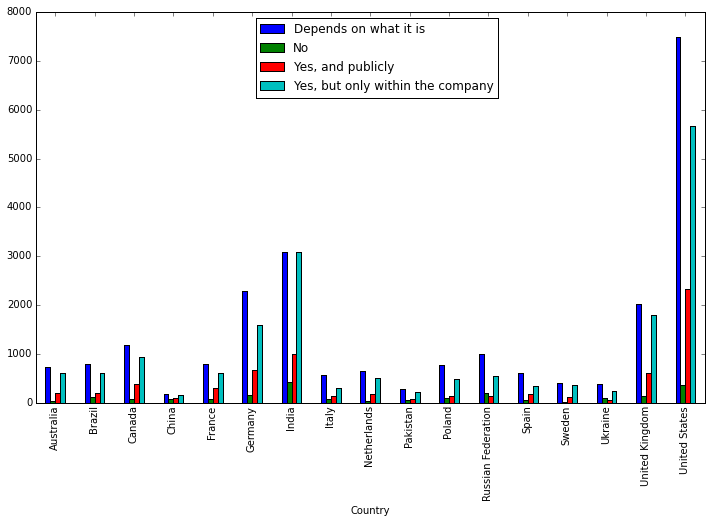

In [24]:
df_2018['Count'] = 1
co = df_2018['Country'].value_counts()
countries = co[co>1000].index.tolist()
ai = df_2018[df_2018.Country.isin(countries)].copy()

ai = ai.groupby(['Country','EthicsReport']).count()
fig, ax = subplots()
ai['Count'].unstack().plot(figsize = (12,7),kind='bar',ax=ax);
ax.legend(bbox_to_anchor=(0.7, 1))

## Ethics Responsible
Results always similar

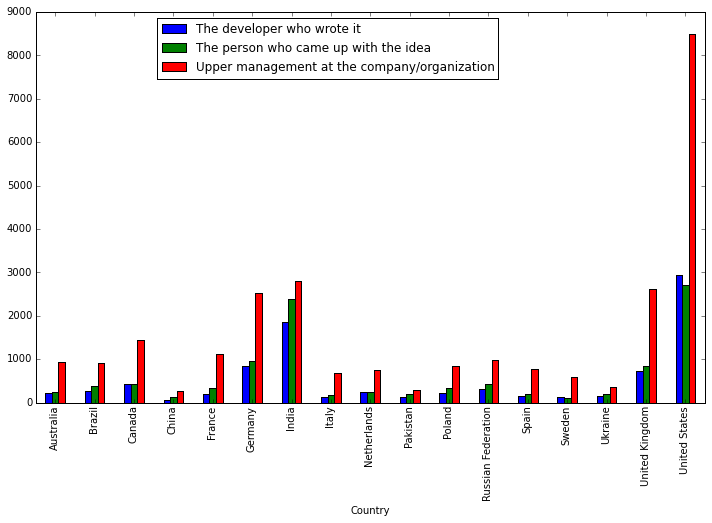

In [25]:
df_2018['Count'] = 1
co = df_2018['Country'].value_counts()
countries = co[co>1000].index.tolist()
ai = df_2018[df_2018.Country.isin(countries)].copy()

ai = ai.groupby(['Country','EthicsResponsible']).count()
fig, ax = subplots()
ai['Count'].unstack().plot(figsize = (12,7),kind='bar',ax=ax);
ax.legend(bbox_to_anchor=(0.7, 1));

## Ethical Implication
Results always similar

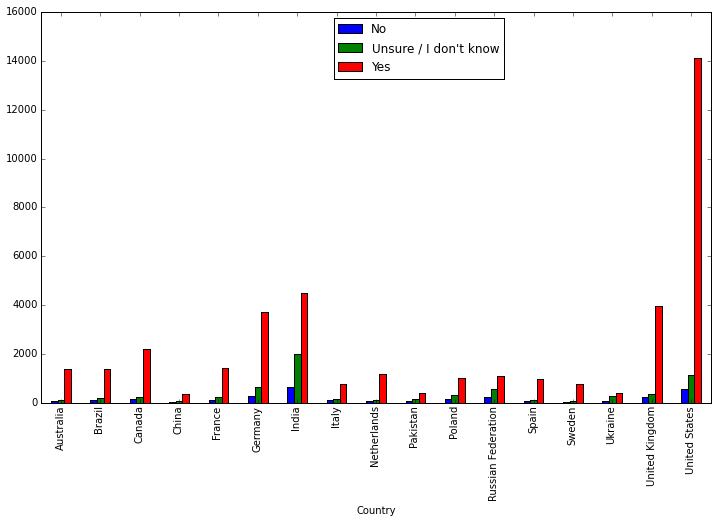

In [26]:
df_2018['Count'] = 1
co = df_2018['Country'].value_counts()
countries = co[co>1000].index.tolist()
ai = df_2018[df_2018.Country.isin(countries)].copy()

ai = ai.groupby(['Country','EthicalImplications']).count()
fig, ax = subplots()
ai['Count'].unstack().plot(figsize = (12,7),kind='bar',ax=ax);
ax.legend(bbox_to_anchor=(0.7, 1));

## Modeling

In [30]:
def company_size_replace(x):
    if isinstance(x, float) and math.isnan(x):
        return x
    elif not type(x.split()[0]) is str:
        return int(x.split()[0].replace(',', ''))
    elif x.split()[0]=='Fewer':
        return 1
    else:
        return int(x.split()[0].replace(',', ''))

def clean_with_dict(x,d):
    if (isinstance(x, float) and math.isnan(x) ) :
        return x
    else:
        return d[x]

def years_coding_replace(x):
    if isinstance(x, float) and math.isnan(x):
        return x
    elif not type(x.split()[0].split('-')[0]) is str:
        return int(x.split()[0].split('-')[0].replace(',', ''))
    elif x.split()[0]=='Fewer':
        return 1
    else:
        return int(x.split()[0].split('-')[0].replace(',', ''))    


age_dict = {'25 - 34 years old':29, '18 - 24 years old':21, '35 - 44 years old':40,
       '45 - 54 years old':50, 'Under 18 years old':18, '55 - 64 years old':60,
       '65 years or older':65}
agree_disagree= {'Strongly agree':1,'Agree':2, 'Neither Agree nor Disagree':3,'Disagree':4,'Strongly disagree':5}

hours_computer = {'1 - 4 hours':1,'5 - 8 hours':5,'9 - 12 hours':9,'Less than 1 hour':0,'Over 12 hours':12}
yes_no = {'Yes':1,'No':0}

In [31]:
def clean_data(df,col):
    '''
    INPUT
    df - pandas dataframe 
    col - column to predict
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    '''
    df = df.dropna(how='all', axis=1)
    
    X= df.dropna(subset=[col], how='any', axis=0)
    
    
    attr_ordinal = X.select_dtypes(include=['float','int'] ).columns.tolist()
    mean_fc = lambda col: col.fillna(col.mean())
    
    
    attr_uniq = []
    tot = X.shape[1]
    count = 0
    for c in attr_ordinal:
        if count%10==0:
            print(str(count)+' of '+str(tot))
        if X[c].min()==0 and X[c].max()==1:
            #X[c] = X[c].fillna(X[c].mode()[0])
            count +=1
            
        elif X[c].min()==1 and X[c].max()==1:
            #print('min max 1',c)
            X[c] = X[c].fillna(0)
            count +=1
            attr_uniq.append(c)
        else:
            #X[c] = X[c].fillna(X[c].mean())
            count +=1
            
    
    X = X.dropna(how='any', axis=0)
    y = X[col]
    X = X.drop(col,axis=1)
    
    attr_object = X.select_dtypes(include=['object'] ).columns.tolist()
    for col in attr_object:
        if count%10:
            print(col)
            print(str(count)+' of '+str(tot))
        try:
            X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=False, dummy_na=False)], axis=1)
        except:
            print('Issue with get dummies for column ',col)
            continue
        count +=1
    
    
    
    return X, y


    

In [32]:
# Cleaning
# Just a set of columns which have been used in previous analysis are kept to reduce the data size and computation power required

col_list = ['Country','Employment','FormalEducation',
            'DevType','YearsCodingProf','ConvertedSalary','AgreeDisagree1',
           'AgreeDisagree2', 'AgreeDisagree3','Age',
           'Dependents','HoursComputer','CompanySize','LanguageWorkedWith','Gender'] 


temp_2018 = df_2018[col_list].dropna(how='any',axis=0).copy()
temp_2018 = temp_2018.dropna(how='any',axis=0)

temp_2018['CompanySize'] = temp_2018['CompanySize'].apply(lambda x: company_size_replace(x))

co = df_2018['Country'].value_counts()
countries = co[co>700].index.tolist()
temp_2018 = temp_2018[temp_2018.Country.isin(countries)].copy()
 
gender_dict = {'Male':'Male','Female':'Female'}
for c in df_2018.Gender.value_counts().index:
    if not c in gender_dict:
        gender_dict[c] = 'Other'
temp_2018.Gender = temp_2018.Gender.apply(lambda x: clean_with_dict(x,gender_dict))

temp_2018 = split_clean(temp_2018,'DevType')
temp_2018 = split_clean(temp_2018,'LanguageWorkedWith')
devtype_list = get_col(temp_2018,'DevType')
for c in devtype_list:
    temp_2018[c] = temp_2018[c].fillna(0).astype('uint8')

temp_2018['Age']= temp_2018['Age'].apply(lambda x:clean_with_dict(x,age_dict))
temp_2018['AgreeDisagree1'] = temp_2018['AgreeDisagree1'].apply(lambda x: clean_with_dict(x,agree_disagree))
temp_2018['AgreeDisagree2'] = temp_2018['AgreeDisagree2'].apply(lambda x: clean_with_dict(x,agree_disagree))
temp_2018['AgreeDisagree3'] = temp_2018['AgreeDisagree3'].apply(lambda x: clean_with_dict(x,agree_disagree) )
temp_2018['YearsCodingProf'] = temp_2018['YearsCodingProf'].apply(lambda x: years_coding_replace(x)) 
temp_2018['HoursComputer'] = temp_2018['HoursComputer'].apply(lambda x: clean_with_dict(x,hours_computer) )
temp_2018['Dependents'] = temp_2018['Dependents'].apply(lambda x: clean_with_dict(x,yes_no) )



In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC,SVR
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X, y = clean_data(temp_2018,'ConvertedSalary')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
#fit the model and obtain pred response
#lm_model = RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=7,min_samples_leaf=3)
lm_model = LinearRegression(normalize=False)    #same results with normalize true or false except that with true the coefficients are extreme
#lm_model = SVR(kernel = 'linear',C=100)
lm_model.fit(X_train, y_train)

print('fit is done')
y_test_preds = lm_model.predict(X_test)
print('y_test is predicted')
y_train_preds = lm_model.predict(X_train)
print('y_train is predicted')

#compute r2
print('r2_score for the test dataset',r2_score(y_test, y_test_preds))
print('r2_score for the train dataset',r2_score(y_train, y_train_preds))

0 of 71
10 of 71
20 of 71
30 of 71
40 of 71
Country
47 of 71
Employment
48 of 71
FormalEducation
49 of 71
fit is done
y_test is predicted
y_train is predicted
r2_score for the test dataset 0.671653542989
r2_score for the train dataset 0.689003547341


* if data is missing for at least one of the column in the row then the row is dropped. As we are only considered in getting an insight in the resulting coefficients of the paramters this is fine enough
* object types that can be transformed in meaningful int type have been converted like HoursComputer or YearsCodingProf
* simple yes/no questions have been also transformed in 0/1
* columns like DevType have been manually encoded 

From 

Respondant / DevType

1          / Back-End; Front-End

2          / Designer

To

Respondant / DevType_Back-End / DevType_Front-End / Designer

1          /      1           /         1         /    0

2          /      0           /         0         /    1




In [37]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    '''
    coefs_df = pd.DataFrame()
    coefs_df['feature'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_.transpose()
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_.transpose())
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

Interestingly, the company size never seems to have a great impact independently of the model chosen or with or without normalization.

In [38]:
coef_df


,feature,coefs,abs_coefs
91,Country_United States,47257.495867,47257.495867
87,Country_Switzerland,45148.473295,45148.473295
77,Country_Israel,35103.886651,35103.886651
66,Country_Australia,29916.408270,29916.408270
76,"Country_Iran, Islamic Republic of...",-27388.597778,27388.597778
81,Country_Pakistan,-24958.574362,24958.574362
75,Country_India,-24200.087904,24200.087904
84,Country_Russian Federation,-20870.026927,20870.026927
79,Country_Mexico,-20429.988429,20429.988429
89,Country_Ukraine,-20291.251614,20291.251614


/Users/juliasuc/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


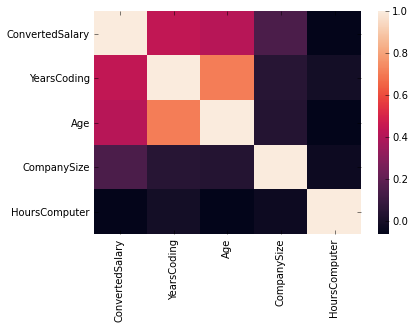

In [361]:
sns.heatmap(temp_2018[['ConvertedSalary','YearsCoding','Age','CompanySize','HoursComputer']].corr() )